<a href="https://colab.research.google.com/github/potulabe/symphonypy/blob/main/notebooks/Symphonypy_simple_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symphonypy usage with your own reference

In [ ]:
!pip install scanpy[leiden] openTSNE symphonypy
!gdown "1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t"

In [3]:
import numpy as np
import seaborn as sns
import scanpy as sc
import symphonypy as sp
import matplotlib.pyplot as plt

sc.set_figure_params(dpi=80)
sns.set_style("ticks")

adata_ref = sc.read_h5ad("PBMC_Satija.h5ad")
adata_ref.obs.head()

,orig.ident,lane,donor,time,celltype.l1,celltype.l2,celltype.l3,Phase
L1_AAACCCACATCAGTCA,P3_3,L1,P3,3,CD8 T,CD8 TEM,CD8 TEM_1,G1
L1_AAACCCATCCACACCT,P3_3,L1,P3,3,CD8 T,CD8 Naive,CD8 Naive,S
L1_AAACCCATCTGCGGAC,P1_0,L1,P1,0,CD4 T,CD4 TCM,CD4 TCM_1,S
L1_AAACCCATCTTAAGGC,P2_3,L1,P2,3,CD4 T,CD4 CTL,CD4 CTL,S
L1_AAACGAAAGATAACAC,P2_3,L1,P2,3,B,B naive,B naive kappa,S


Reference preprocessing and preparation for label transfer using Harmony. We recommend using the same normalization factor for reference and query datasets.

In [4]:
sc.pp.normalize_total(adata_ref, target_sum=1e5)
sc.pp.log1p(adata_ref)
sc.pp.highly_variable_genes(
    adata_ref,
    batch_key="orig.ident",
    n_top_genes=3000,
)
adata_ref.raw = adata_ref

In [5]:
adata_ref = adata_ref[:, adata_ref.var.highly_variable]
sc.pp.scale(adata_ref, max_value=10)
sc.pp.pca(adata_ref, n_comps=30, zero_center=False)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


The following step should be performed with `harmony_integrate` function from Symphonypy package (it appends additional information to AnnData object's `.uns` slot).

In [6]:
sp.pp.harmony_integrate(adata_ref, key="orig.ident", verbose=True, max_iter_harmony=20)

2024-04-09 16:33:03,320 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


Harmony integration with harmonypy is preforming.


2024-04-09 16:33:09,883 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2024-04-09 16:33:10,051 - harmonypy - INFO - Iteration 1 of 20
INFO:harmonypy:Iteration 1 of 20
2024-04-09 16:33:17,282 - harmonypy - INFO - Iteration 2 of 20
INFO:harmonypy:Iteration 2 of 20
2024-04-09 16:33:25,645 - harmonypy - INFO - Iteration 3 of 20
INFO:harmonypy:Iteration 3 of 20
2024-04-09 16:33:33,824 - harmonypy - INFO - Iteration 4 of 20
INFO:harmonypy:Iteration 4 of 20
2024-04-09 16:33:41,147 - harmonypy - INFO - Iteration 5 of 20
INFO:harmonypy:Iteration 5 of 20
2024-04-09 16:33:49,117 - harmonypy - INFO - Iteration 6 of 20
INFO:harmonypy:Iteration 6 of 20
2024-04-09 16:33:52,868 - harmonypy - INFO - Iteration 7 of 20
INFO:harmonypy:Iteration 7 of 20
2024-04-09 16:34:00,917 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


Now let's compute UMAP for futher visualization and its coordinates transfer, and perform clustering with Leiden algorithm.

In [7]:
sc.pp.neighbors(adata_ref, use_rep="X_pca_harmony")
sc.tl.umap(adata_ref)

<ipython-input-7-88438f323b91>:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_ref)


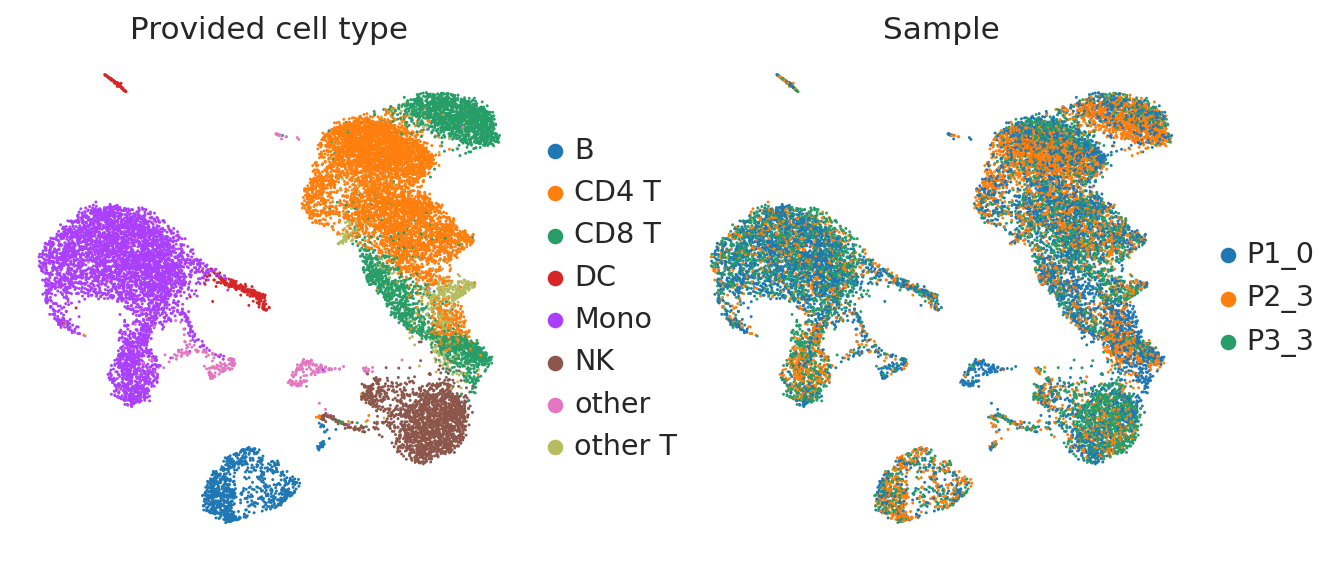

In [8]:
sc.pl.umap(
    adata_ref,
    color=["celltype.l1", "orig.ident"],
    frameon=False,
    title=["Provided cell type", "Sample"],
)

## Query mapping and label transfer

In [9]:
adata_query = sc.datasets.pbmc3k()
sc.pp.normalize_total(adata_query, target_sum=1e5)
sc.pp.log1p(adata_query)

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

Let's do embedding mapping and label transferring with symphonypy.

In [10]:
# Mapping Harmony coordinates
sp.tl.map_embedding(adata_query=adata_query, adata_ref=adata_ref)

# Mapping UMAP coordinates
sp.tl.ingest(adata_query=adata_query, adata_ref=adata_ref)

# Labels prediction
sp.tl.transfer_labels_kNN(
    adata_query=adata_query,
    adata_ref=adata_ref,
    ref_labels=["celltype.l1"],
)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Now we can calculate mapping score per cell and per cluster (see [paper](https://www.nature.com/articles/s41467-021-25957-x#Sec14) for more details).

In [11]:
# Per cell mapping score
sp.tl.per_cell_confidence(
    adata_query=adata_query,
    adata_ref=adata_ref,
)

In [12]:
# Per cluster mapping score
def cluster_data(adata, resolution=1):
  adata = adata.copy()
  sc.pp.scale(adata, max_value=10)
  sc.pp.pca(adata, n_comps=30)
  sc.pp.neighbors(adata)
  sc.tl.leiden(adata, resolution=resolution)
  return adata.obs["leiden"]

adata_query.obs["query_leiden"] = cluster_data(adata_query)

sp.tl.per_cluster_confidence(
    adata_query=adata_query,
    adata_ref=adata_ref,
    cluster_key="query_leiden",
)

<Axes: title={'center': 'Reference dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

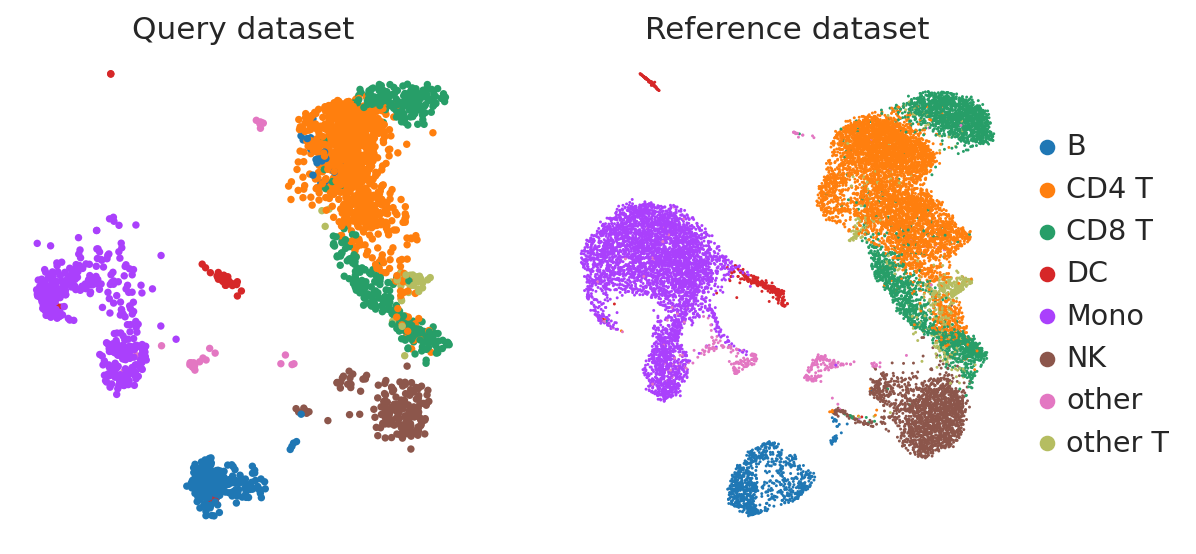

In [13]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.umap(
    adata_query,
    color="celltype.l1",
    frameon=False,
    title="Query dataset",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    adata_ref,
    color="celltype.l1",
    frameon=False,
    title="Reference dataset",
    ax=axes[1],
    show=False,
)


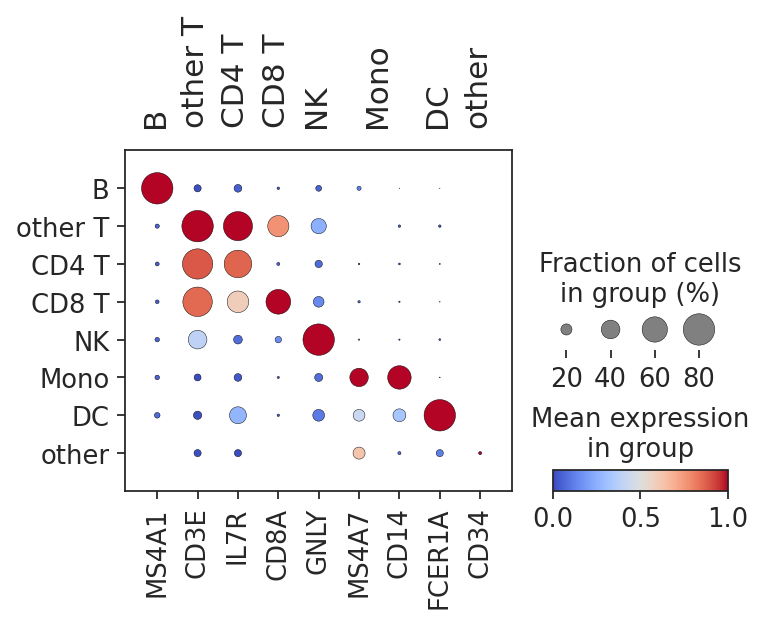

In [14]:
marker_genes = {
    "B": ["MS4A1"],
    "other T": ["CD3E"],
    "CD4 T": ["IL7R"],
    "CD8 T": ["CD8A"],
    "NK": ["GNLY"],
    "Mono": ["MS4A7", "CD14"],
    "DC": ["FCER1A"],
    "other": ["CD34"],
}

adata_query.obs["celltype.l1"] = (
    adata_query.
    obs["celltype.l1"].
    cat.
    reorder_categories(
        list(marker_genes.keys())
    )
)

sc.pl.dotplot(
    adata_query,
    var_names=marker_genes,
    groupby="celltype.l1",
    standard_scale="var",
    dot_max=0.8,
    cmap="coolwarm",
)

## t-SNE building and mapping with `openTSNE`
Here we use `openTSNE` t-SNE implementation that makes possible to add data points to existing t-SNE embedding.

In [15]:
tSNE_model = sp.tl.tsne(adata_ref, use_rep="X_pca_harmony", return_model=True)
sp.tl.tsne(adata_query, use_rep="X_pca_harmony", use_model=tSNE_model)

In [16]:
celltype_colors = dict(zip(
    adata_ref.obs["celltype.l1"].cat.categories,
    adata_ref.uns["celltype.l1_colors"],
))
adata_query.uns["celltype.l1_colors"] = [
    celltype_colors[ct] for ct in adata_query.obs["celltype.l1"].cat.categories
]

<Axes: title={'center': 'Query dataset'}, xlabel='tSNE1', ylabel='tSNE2'>

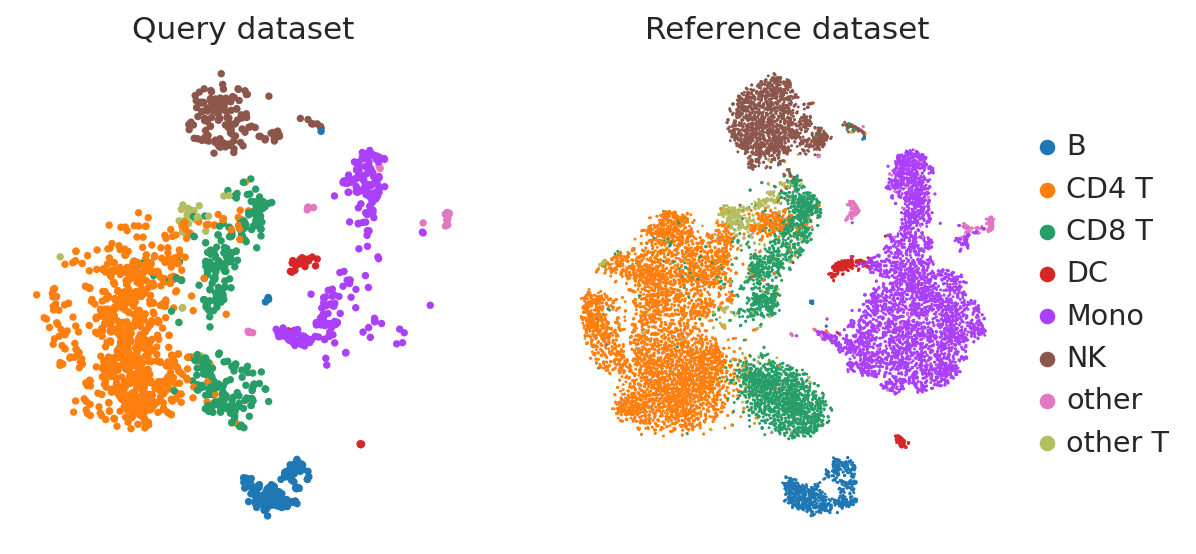

In [17]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.tsne(
    adata_ref,
    color="celltype.l1",
    frameon=False,
    title="Reference dataset",
    ax=axes[1],
    show=False,
)

sc.pl.tsne(
    adata_query,
    color="celltype.l1",
    frameon=False,
    title="Query dataset",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

You can save the model with `pickle` or using the argument `save_path` of `sp.tl.tsne()`.

In [18]:
import pickle

with open("PBMC_tSNE_model.pickle", "wb") as model_file:
    pickle.dump(tSNE_model, model_file, protocol=pickle.HIGHEST_PROTOCOL)

## Mapping confidence metrics

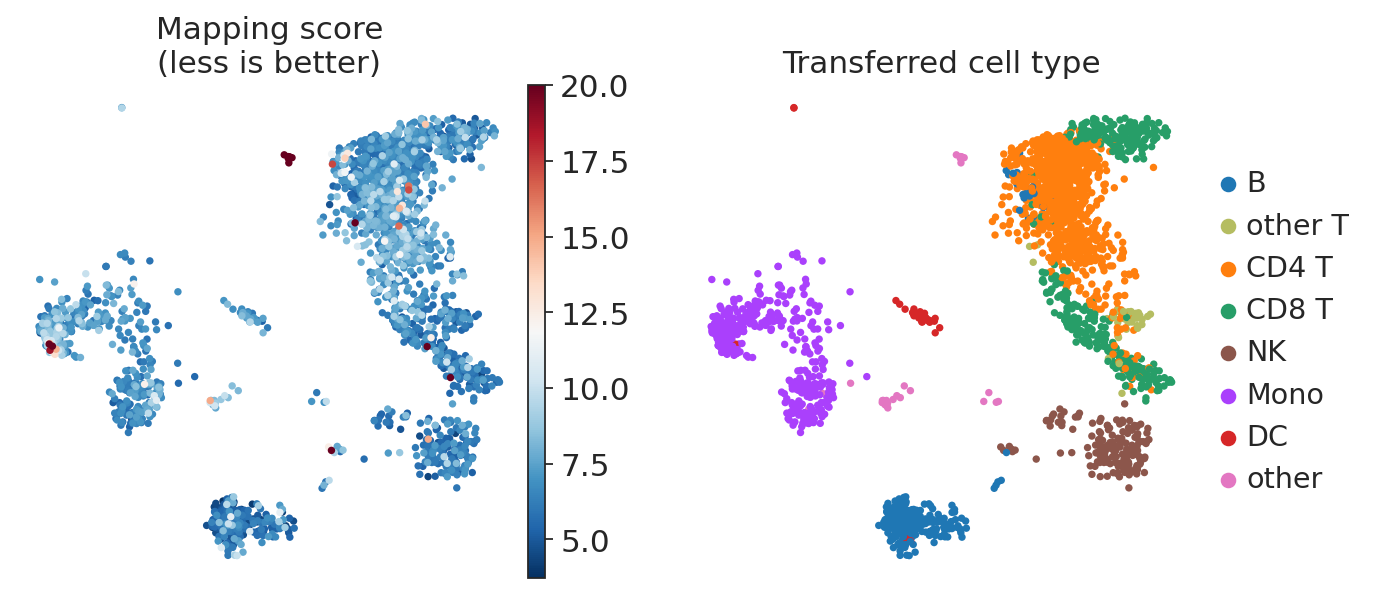

In [19]:
sc.pl.umap(
    adata_query,
    color=["symphony_per_cell_dist", "celltype.l1"],
    frameon=False,
    title=["Mapping score\n(less is better)", "Transferred cell type"],
    vmax=20,
    cmap="RdBu_r",
)

(0.0, 12.289875026902362)

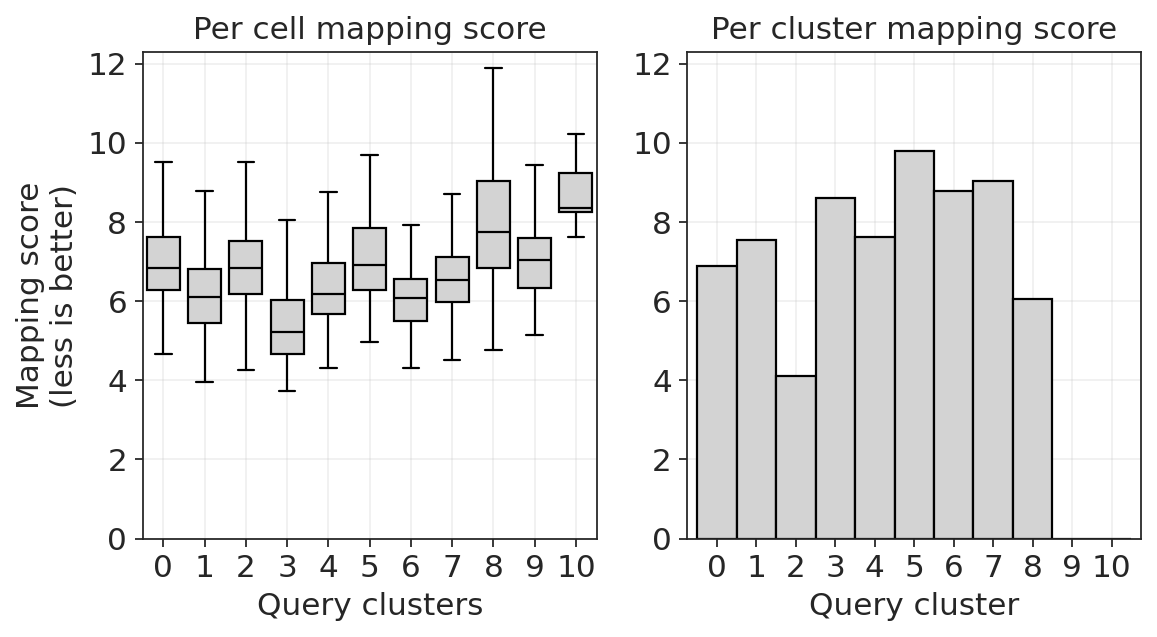

In [20]:
import seaborn as sns
sns.set_style("ticks")

boxplot_colordict = {
    "boxprops": {"edgecolor": "black"},
    "medianprops": {"color": "black"},
    "whiskerprops": {"color": "black"},
    "capprops": {"color": "black"},
}

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sns.boxplot(
    x="query_leiden",
    y="symphony_per_cell_dist",
    data=adata_query.obs,
    showfliers=False,
    color="lightgrey",
    linewidth=1,
    ax=axes[0],
    **boxplot_colordict,
)
axes[0].set_xlabel("Query clusters")
axes[0].set_ylabel("Mapping score\n(less is better)")
axes[0].set_title("Per cell mapping score")
axes[0].grid(alpha=0.3)

adata_query.uns["symphony_per_cluster_dist"]["dist"].plot.bar(
    width=1,
    edgecolor="black",
    color="lightgrey",
    ax=axes[1],
)
axes[1].set_xlabel("Query cluster")
axes[1].set_title("Per cluster mapping score")
axes[1].grid(alpha=0.3)
axes[1].tick_params(axis="x", labelrotation=0)

ylim = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, ylim)
axes[1].set_ylim(0, ylim)